In [1]:
"""
Created on Saturday Januyaray 04, 2025

@author: AFTAB HASSAN

"""
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import joblib
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense ,BatchNormalization,Dropout,SimpleRNN,LeakyReLU,Flatten,Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def custom_activation(x, beta = 0.5):
        return (K.sigmoid(beta * x) * x)
get_custom_objects().update({'custom_activation': Activation(custom_activation)})
from prophet import Prophet
import torch
from gluonts.torch.distributions.studentT import StudentTOutput
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

import math
import time
import os
import itertools
from copy import deepcopy
from itertools import islice
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def CalMape(actual_data, fit_data, term):
    #term  = 12
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i = 0
    count = 0
    ape = 0
    for actualVal in lastActualData:
        #print(actualVal,lastFitData[i])
        if(actualVal != 0):
            val = (abs(actualVal - lastFitData[i])/actualVal)*100
            #val=abs(val)
            #print(val)
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            return 0
    else:      
        return mape_cal

In [3]:
def CalWMape(actual_data, fit_data, term):
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i=0
    count = 0
    sump_actual=0
    sum_actual_fitted=0
    
    for actualVal in lastActualData:
        if(actualVal != 0):
            sum_actual_fitted += abs(actualVal - lastFitData[i])
            sump_actual +=actualVal
            count = count + 1        
        i = i+1     
          
    if(count!=0):
        wmape_cal = (sum_actual_fitted/sump_actual)*100
    else:
        wmape_cal=99        
     
    if(np.isnan(wmape_cal).any()):        
        return 0
    else:      
        return wmape_cal  

In [4]:
def mape_recalculate(temp_result):  
    temp_wmape=[]
    temp=[]
    i = 0
    count = 0
    ape = 0
    for item in temp_result:
        #print(actualVal,lastFitData[i])
        temp_wmape.append(item[5])
        actualVal=item[8]
        forecastVal=item[7]
        if(actualVal != 0):
            val = (abs(actualVal - forecastVal)/actualVal)*100
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            mape_cal=0

    #print(mape_cal)
    avg_wmape=sum(temp_wmape)/len(temp_wmape)
    for x in temp_result:
        x[5]=round(avg_wmape,3)
        x[6]=round(mape_cal,3)
        temp.append(x)
    return temp

In [5]:
output=[]
temp_output=[]
# Load Data 

# df = pd.read_csv('input/data_template2.csv')
# col=['ALL_DATE','Region','SKU','Type','QTY','Feature1','Feature2']
df = pd.read_csv('input/sales_data.csv')
col=['ALL_DATE','Region','SKU','Type','QTY']
df.columns=col
df["ALL_DATE"]=pd.to_datetime(df["ALL_DATE"],format="%d-%m-%Y")
data=df.copy()
df.set_index("ALL_DATE", inplace=True)

In [6]:
# display head data
df.head()

,Region,SKU,Type,QTY
ALL_DATE,,,,
2018-01-01,Hyderabad,Food Oil,Sales,97.83
2018-02-01,Hyderabad,Food Oil,Sales,93.24
2018-03-01,Hyderabad,Food Oil,Sales,152.40
2018-04-01,Hyderabad,Food Oil,Sales,142.08
2018-05-01,Hyderabad,Food Oil,Sales,102.54


In [7]:
# display tail data
df.tail()

,Region,SKU,Type,QTY
ALL_DATE,,,,
2022-08-01,Hyderabad,Food Oil,Sales,363.27
2022-09-01,Hyderabad,Food Oil,Sales,254.79
2022-10-01,Hyderabad,Food Oil,Sales,307.41
2022-11-01,Hyderabad,Food Oil,Sales,278.29
2022-12-01,Hyderabad,Food Oil,Sales,768.13


In [8]:
df.describe()

,QTY
count,60.000000
mean,199.248333
std,112.567325
min,74.870000
25%,131.912500
50%,176.615000
75%,242.167500
max,768.130000


In [9]:
df.shape

(60, 4)

In [10]:
# display column name
print(df.columns)

df.drop(["Type"],axis=1,inplace=True,errors="ignore")

Index(['Region', 'SKU', 'Type', 'QTY'], dtype='object')


In [11]:
df['QTY'].describe()

count     60.000000
mean     199.248333
std      112.567325
min       74.870000
25%      131.912500
50%      176.615000
75%      242.167500
max      768.130000
Name: QTY, dtype: float64

In [12]:
result = adfuller(df['QTY'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: 1.8752739889714711
n_lags: 0.9984871843524818
p-value: 0.9984871843524818
Critial Values:
   1%, -3.5745892596209488
Critial Values:
   5%, -2.9239543084490744
Critial Values:
   10%, -2.6000391840277777


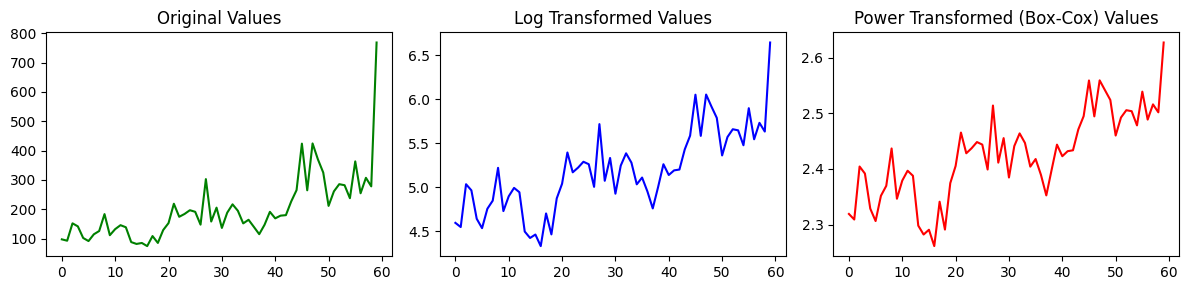

Best Lambda for Box-Cox Transformation: -0.34123069679639123


In [13]:
# Log Transformation
data["Log_QTY"] = np.log(data["QTY"] + 1)  # Adding 1 to handle zero values

# Power Transformation (Box-Cox)
data["BoxCox_QTY"], best_lambda = boxcox(data["QTY"] + 1)  # Box-Cox requires positive values

# Plot original vs transformed data
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
# Original values
axes[0].plot(data.index, data["QTY"], color='green')
axes[0].set_title("Original Values")

# Log Transformed values
axes[1].plot(data.index, data["Log_QTY"], color='blue')
axes[1].set_title("Log Transformed Values")


# Box-Cox Transformed values
axes[2].plot(data.index, data["BoxCox_QTY"], color='red')
axes[2].set_title("Power Transformed (Box-Cox) Values")

plt.tight_layout()
plt.show()

# Print best lambda for Box-Cox
print(f"Best Lambda for Box-Cox Transformation: {best_lambda}")

In [14]:
# df_area_temp2=df[df['Region'].isin(["Hyderabad"])]
# df_temp2=df_area_temp2[df_area_temp2['SKU'].isin(["SKU1"])]  

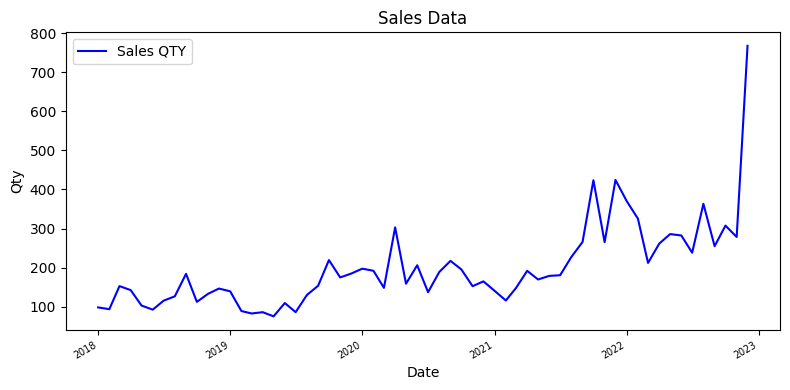

In [15]:
# Plotting the results for train dataset
plt.figure(figsize=(8, 4))
plt.plot( df.index, df['QTY'], label='Sales QTY', color='blue')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data')
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
def save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,inc_loop,sales_qty):
    temp_output=[]
    i=inc_loop
    negFlag=1
    sales_qty=float(sales_qty)
    #print("Sales QTY = ",sales_qty)
    for fvalue in forecasted_value:                      
        if(fvalue<0):
            negFlag=0
            break            
    
    if(negFlag==1):            
        for fvalue in forecasted_value: 
            fvalue=round(float(fvalue),3)       
            #i+=1
            if(math.isnan(fvalue)==True):  
                #print(np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
    else:
        for fvalue in forecasted_value:  
            fvalue=round(float(fvalue),3)              
            #i+=1
            if(math.isnan(fvalue)==True or fvalue<0): 
                #print(">>>>>>>",np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)                
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
                
    return temp_output    


In [17]:
def forcast_output_CSV(output,sales_column):
    #print("Result is writing into csv")
    
    data=[]   

    for x in output:
        #print ('x=',x)   
        start_year=x[0]
        variable='X'+str(x[1])
        region = x[2]
        sku_name=x[3]     
        model_name=x[4] 
        accuracy_wmape=x[5]
        accuracy_mape=x[6]      
        value=x[7]
        sales_qty=x[8]

        #print(fc_model_code,sku_name,model_name,accuracy_me,accuracy_rsme,accuracy_mae,accuracy_mpe,accuracy_mape,accuracy_mase,variable,value)
        data.append([start_year,region,sku_name,model_name,accuracy_wmape,accuracy_mape,variable,value,sales_qty])
        
    fp=open("output/ForecastedResult_"+sales_column+".csv","w")                                        

    header='Star Year'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Overall MAPE'+','+'Test MAPE'+','+'Steps'+','+'Forecast QTY' +','+'Sales QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in data:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()


In [18]:
def fitted_output_CSV(temp_output,sales_column):
    print("Result is writing into fitted_output_CSV")
        
    fp=open("output/FittedResult_"+sales_column+".csv","w")                                        

    header='Date'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Sales QTY' +','+'Fitted QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in temp_output:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()

In [19]:
def evaluate_arima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(1,4)
    d = range(1,3)
    q = range(1,4)
        
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))
    #print(pdq)
        
    best_aic = np.inf
    best_pdq = None
    temp_model = None
    for param in pdq:   
        temp_model = ARIMA(data,order=param)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param 
    #print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))  
      
    return best_pdq

In [20]:
def ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column):      
        
    mod = ARIMA(orig_data, order=best_pdq)
    res = mod.fit()  
    pred_data = res.predict()  
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    #print("ARIMA Train MAPE : ",wmape)
    if(len(test_data)>0):
        mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0        
    #print("ARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data

In [21]:
def evaluate_sarima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))        
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
        
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None
    for param in pdq:   
        for param_seasonal in seasonal_pdq: 
            temp_model = SARIMAX(data,order=param,seasonal_order = param_seasonal,enforce_invertibility=True,enforce_stationarity=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
    #print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic)) 
    
    return  best_pdq,best_seasonal_pdq

In [22]:
def SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column):        
        
    mod = SARIMAX(orig_data,order=best_pdq,seasonal_order=best_seasonal_pdq)
    res = mod.fit(disp=False)     
    pred_data = res.predict()    
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
   
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    #print("SARIMA Train MAPE : ",wmape)
    if(len(test_data)>0):
        mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
    #print("SARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [23]:
def Holt_Winters_Model(step,orig_data,model_type,train_data,test_data,sales_column):  
    #print("In holtz winter")      
    if(model_type=='add'):
        mod = ExponentialSmoothing(orig_data , initialization_method= 'legacy-heuristic',seasonal_periods=12,trend=None, seasonal='add')
    else:
        mod = ExponentialSmoothing(orig_data ,initialization_method= 'legacy-heuristic',seasonal_periods=12 ,trend='mul',seasonal='mul')
        
    #res = mod.fit(optimized=True, use_brute=False, remove_bias=True)  
    res = mod.fit(optimized=True, use_brute=True, remove_bias=True)  

    #print(res.summary())
   
    pred_data = res.fittedvalues
    
    forecasted_value = res.forecast(steps = step)
    #print("forecasted Value",forecasted_value)
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data)>0):
        mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
    #print("Test Holt_Winters_Model MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [24]:
def _get_lag_llama_predictions(dataset, prediction_length, tune_type,num_samples=100):
    # Load the checkpoint with map_location set to 'cpu'
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    if(tune_type=="tune"):
        epoch_range={"max_epochs": 10,}
    else:
        epoch_range={"max_epochs": 200,}
    
    # Initialize the estimator with the required arguments
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0005,
        
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (32 + prediction_length) / estimator_args["context_length"]),
        # },
        
        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = epoch_range, # <- lightning trainer arguments
    )

    # Create the lightning module, transformation, and predictor
    if(tune_type=="tune"):
        predictor = estimator.train(dataset, cache_data=True, shuffle_buffer_length=1000)
    else:
        lightning_module = estimator.create_lightning_module()
        transformation = estimator.create_transformation()
        predictor = estimator.create_predictor(transformation, lightning_module)
        
    # Generate forecasts and time series predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss ,predictor

In [25]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()
    #print(dataset)
    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

In [26]:
def Lagllama_Model(step,train_data2,test_data2,sales_column,time_freq):
    tune_type="tune"
    df =train_data2.copy()
    #print("sales_column : ",sales_column)
    df=df[[sales_column]]

    backtest_dataset = _get_lag_llama_dataset(dataset=df)
    #print(backtest_dataset)
    prediction_length = step  # prediction length
    num_samples = len(df) # 36 is sampled from the distribution for each timestep
    forecasts, tss,model_fit = _get_lag_llama_predictions(
    backtest_dataset, prediction_length, tune_type,num_samples
    )
    # Extract forecasted mean values
    forecast_index = pd.date_range(start=df.index[-1], periods=prediction_length+1, freq=time_freq)[1:]    
    forecast_values = [forecast.mean for forecast in forecasts]
    forecast_df = pd.DataFrame(forecast_values[0], index=forecast_index, columns=['Forecast'])    
    forecasted_value=forecast_df['Forecast'].values    
    #print("Lag-llama forecasted Value",np.round(forecasted_value,3))
    
    fitted_values=tss[0].values.reshape(1,-1)[0]
    if(len(test_data2)>0):        
        test_data=np.array(test_data2[sales_column])
        mae = mean_absolute_error(test_data, forecasted_value)
        mape = CalMape(test_data, forecasted_value, len(forecasted_value))
        rmse = np.sqrt(mean_squared_error(test_data, forecasted_value))
        r2 = r2_score(test_data, forecasted_value)
    else:
        evaluator = Evaluator()
        agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
        mae = round(agg_metrics['abs_error'],2)
        mape = round(agg_metrics['MAPE']*100,2)
        rmse = round(agg_metrics['RMSE'],2)
        train_data=np.array(train_data2[sales_column])
        r2 = r2_score(train_data, fitted_values)
        
    #print("Lag LLama : ",mae,mape,rmse,r2)

    return np.round(forecasted_value,3),fitted_values,mae,mape,rmse,r2

In [27]:
# ********** Random Forest Regression Model (RFR Model)
def XGBR_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    train_data =train_data2.copy()
    train_data = train_data.reset_index()
    train_data['year'] = train_data[date_column].dt.year
    train_data['month'] = train_data[date_column].dt.month
    #train_data['day'] = train_data[date_column].dt.day 
    if(len(numeric_cols)>1):
        sales_column = numeric_cols
        
    X_train = train_data[['year', 'month']]
    orig_data = train_data[sales_column].values 
    
    #max_est=int(max(orig_data))
    #model = XGBRegressor(booster='gbtree', objective='reg:squarederror', max_depth=2,n_estimators=(max_est+int(max_est*0.10)), random_state=3, n_jobs=-1) 
    
    model = XGBRegressor(booster='gbtree', objective='reg:squarederror', max_depth=3,random_state= 42,n_jobs=-1)

    model_fit = model.fit(X_train,orig_data)
    #joblib.dump(model_fit, 'xgbr_model.pkl')

    fitted_data = model_fit.predict(X_train)
    if(len(test_data2)>0):
        test_data =test_data2.copy()
        test_data = test_data.reset_index()
        test_data['year'] = test_data[date_column].dt.year
        test_data['month'] = test_data[date_column].dt.month
        X_test=test_data[['year', 'month']]    
    else:        
        forecast_date['year'] = forecast_date[date_column].apply(lambda x: int(x[-4:]))
        forecast_date['month'] = forecast_date[date_column].apply(lambda x: int(x[3:5]))
        X_test=forecast_date[['year', 'month']]    
        
    forecasted_value = model_fit.predict(X_test)
    temp=[]
    fitt_temp=[]
    if(len(numeric_cols)>1):
        forecasted_value2=forecasted_value
        for x in forecasted_value:
            temp.append(x[0])
        forecasted_value=temp
        for x in fitted_data:            
            fitt_temp.append(x[0])
            fitted_data=fitt_temp
    else:
        forecasted_value2=forecasted_value

            
    wmape=round(CalMape(train_data[numeric_cols[0]],fitted_data,len(fitted_data)),3)
    #print("Train XGBR MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(test_data[numeric_cols[0]],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value,3),mape,wmape,fitted_data
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value2,3),mape,wmape,fitted_data
    else:
        return np.round(forecasted_value,3),mape,wmape,fitted_data

In [28]:
# ********** Random Forest Regression Model
def RFR_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    #print("IN RFR_Model ",sales_column)
    train_data =train_data2.copy()
    train_data = train_data.reset_index()
    train_data['year'] = train_data[date_column].dt.year
    train_data['month'] = train_data[date_column].dt.month
    #train_data['day'] = train_data[date_column].dt.day     
    if(len(numeric_cols)>1):
        sales_column = numeric_cols
        
    X_train = train_data[['year', 'month']]
    orig_data = train_data[sales_column]     
    
    model = RandomForestRegressor(random_state= 42,n_jobs=-1)

    model_fit = model.fit(X_train,orig_data)
    #joblib.dump(model_fit, 'rfr_model.pkl')

    fitted_data = model_fit.predict(X_train)
    if(len(test_data2)>0):
        test_data =test_data2.copy()
        test_data = test_data.reset_index()
        test_data['year'] = test_data[date_column].dt.year
        test_data['month'] = test_data[date_column].dt.month
        X_test=test_data[['year', 'month']]    
    else:        
        forecast_date['year'] = forecast_date[date_column].apply(lambda x: int(x[-4:]))
        forecast_date['month'] = forecast_date[date_column].apply(lambda x: int(x[3:5]))
        X_test=forecast_date[['year', 'month']]    
        
    forecasted_value = model_fit.predict(X_test)
    
    temp=[]
    fitt_temp=[]
    if(len(numeric_cols)>1):
        forecasted_value2=forecasted_value
        for x in forecasted_value:
            temp.append(x[0])
        forecasted_value=temp
        for x in fitted_data:            
            fitt_temp.append(x[0])
            fitted_data=fitt_temp
    else:
        forecasted_value2=forecasted_value
    
    wmape=round(CalMape(train_data[numeric_cols[0]],fitted_data,len(fitted_data)),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(test_data[numeric_cols[0]],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value,3),mape,wmape,fitted_data
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value2,3),mape,wmape,fitted_data
    else:
        return np.round(forecasted_value,3),mape,wmape,fitted_data

In [29]:
# ********** Random Forest Regression Model
def SVR_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    #print("IN RFR_Model ",sales_column)
    train_data =train_data2.copy()
    train_data = train_data.reset_index()
    train_data['year'] = train_data[date_column].dt.year
    train_data['month'] = train_data[date_column].dt.month
    #train_data['day'] = train_data[date_column].dt.day 
    
    value_columns=[]
    if(len(value_columns)>0):
        sales_column = [sales_column]+value_columns
        
    X_train = train_data[['year', 'month']]
    orig_data = train_data[sales_column]     
    
    # Define the parameter grid for hyper-parameter tuning
    param_grid = {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100, 200,300,400,500,600,700,800,900,1000],
        'gamma': [0.01, 0.1, 0.5, 1, 'scale', 'auto'],
        'epsilon': [0.001, 0.005, 0.01, 0.1, 0.5]
    }
    # Initialize SVR model
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    # Fit the grid search to the data
    grid_search.fit(X_train, orig_data)
    model = grid_search.best_estimator_   
    
    model_fit = model.fit(X_train,orig_data)    
    #joblib.dump(model_fit, 'svr_model.pkl')

    fitted_data = model_fit.predict(X_train)
    
    if(len(test_data2)>0):
        test_data =test_data2.copy()
        test_data = test_data.reset_index()
        test_data['year'] = test_data[date_column].dt.year
        test_data['month'] = test_data[date_column].dt.month
        X_test=test_data[['year', 'month']]    
    else:        
        forecast_date['year'] = forecast_date[date_column].apply(lambda x: int(x[-4:]))
        forecast_date['month'] = forecast_date[date_column].apply(lambda x: int(x[3:5]))
        X_test=forecast_date[['year', 'month']]    
        
    forecasted_value = model_fit.predict(X_test)
    
    temp=[]
    fitt_temp=[]
    if(len(value_columns)>0):
        for x in forecasted_value:
            temp.append(x[0])
        forecasted_value=temp
        for x in fitted_data:            
            fitt_temp.append(x[0])
            fitted_data=fitt_temp
    
    wmape=round(CalMape(orig_data,fitted_data,len(fitted_data)),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
        
    return np.round(forecasted_value,3),mape,wmape,fitted_data

In [30]:
# ********** Expert Model (EXPERT Model)
def EXPERT_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    train_data =train_data2.copy()
    train_data = train_data.reset_index()
    train_data['year'] = train_data[date_column].dt.year
    train_data['month'] = train_data[date_column].dt.month
    #train_data['day'] = train_data[date_column].dt.day 
    
    if(len(numeric_cols)>1):
        sales_column = numeric_cols
        
    X_train = train_data[['year', 'month']]
    orig_data = train_data[sales_column] 
    if(len(numeric_cols)>1):
        orig_data2 = train_data[numeric_cols[0]]
    else:
        orig_data2 = train_data[sales_column]
    max_est=int(max(orig_data2))  
        
    reg1 = GradientBoostingRegressor(n_estimators=(max_est+int(max_est*0.10)), learning_rate=0.1, max_depth=2, random_state=2,loss='squared_error')
    reg2 = RandomForestRegressor(random_state= 24,n_jobs=-1)
    reg3 = XGBRegressor(booster='gbtree', objective='reg:squarederror', max_depth=2,n_estimators=(max_est+int(max_est*0.10)), random_state=3, n_jobs=-1)        
    model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2),('xgb', reg3)])
    
    if(len(numeric_cols)>1):
        model = MultiOutputRegressor(model)
        

    model_fit = model.fit(X_train,orig_data)
    #joblib.dump(model_fit, 'expert_model.pkl')

    fitted_data = model_fit.predict(X_train)
    if(len(test_data2)>0):
        test_data =test_data2.copy()
        test_data = test_data.reset_index()
        test_data['year'] = test_data[date_column].dt.year
        test_data['month'] = test_data[date_column].dt.month
        X_test=test_data[['year', 'month']]    
    else:        
        forecast_date['year'] = forecast_date[date_column].apply(lambda x: int(x[-4:]))
        forecast_date['month'] = forecast_date[date_column].apply(lambda x: int(x[3:5]))
        X_test=forecast_date[['year', 'month']]    
        
    forecasted_value = model_fit.predict(X_test)
    
    temp=[]
    fitt_temp=[]
    if(len(numeric_cols)>1):
        forecasted_value2=forecasted_value
        for x in forecasted_value:
            temp.append(x[0])
        forecasted_value=temp
        for x in fitted_data:            
            fitt_temp.append(x[0])
            fitted_data=fitt_temp
    else:
        forecasted_value2=forecasted_value
    
    wmape=round(CalMape(train_data[numeric_cols[0]],fitted_data,len(fitted_data)),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(test_data[numeric_cols[0]],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value,3),mape,wmape,fitted_data
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value,3),np.round(forecasted_value2,3),mape,wmape,fitted_data
    else:
        return np.round(forecasted_value,3),mape,wmape,fitted_data

In [31]:
# ********** Random Forest Regression Model
def RFR_DL_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    #print("IN RFR_Model ",sales_column)
    train_data =train_data2.copy()
    train_data = train_data.reset_index()
    train_data['year'] = train_data[date_column].dt.year
    train_data['month'] = train_data[date_column].dt.month
    #train_data['day'] = train_data[date_column].dt.day 
    
    value_columns=[]
    if(len(value_columns)>0):
        sales_column = [sales_column]+value_columns
        
    X_train = train_data[['year', 'month']]
    orig_data = train_data[sales_column]     
    
    model = RandomForestRegressor(random_state= 42,n_jobs=-1)
    
    model_fit = model.fit(X_train,orig_data)
    fitted_data = model_fit.predict(X_train)
    if(len(test_data2)>0):
        test_data =test_data2.copy()
        test_data = test_data.reset_index()
        test_data['year'] = test_data[date_column].dt.year
        test_data['month'] = test_data[date_column].dt.month
        X_test=test_data[['year', 'month']]    
    else:        
        forecast_date['year'] = forecast_date[date_column].apply(lambda x: int(x[-4:]))
        forecast_date['month'] = forecast_date[date_column].apply(lambda x: int(x[3:5]))
        X_test=forecast_date[['year', 'month']]    
        
    forecasted_value = model_fit.predict(X_test)
    
    temp=[]
    fitt_temp=[]
    if(len(value_columns)>0):
        for x in forecasted_value:
            temp.append(x[0])
        forecasted_value=temp
        for x in fitted_data:            
            fitt_temp.append(x[0])
            fitted_data=fitt_temp
    
    wmape=round(CalMape(orig_data,fitted_data,len(fitted_data)),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    else:
        mape=0
        
    return np.round(forecasted_value,3),mape,wmape,fitted_data

In [32]:
def LSTM_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    df2 =train_data2.copy()
    df2 = df2.reset_index()
    #print("In LSTM_MOdel")
    sales_column2=deepcopy(sales_column)
    ln=len(numeric_cols)
    sales_column = numeric_cols  
    data=df2[sales_column]

    # Reshape data for LSTM
    train_data = data[sales_column].values.reshape(-1, ln)
    #print("Shape : ",train_data.shape)
    leaky_relu_layer = tf.keras.layers.LeakyReLU(alpha=0.2) 
    if(ln>1):        
        # # Create the LSTM model
        model = Sequential()    
        model.add(LSTM(units=64, activation=leaky_relu_layer,input_shape=(train_data2.shape[1], 1), return_sequences=True))
        model.add(LSTM(units=32,activation='relu', return_sequences=True))
        model.add(Dropout(0.2))    
        model.add(Dense(units=1))
    else:        
        model = Sequential()    
        model.add(LSTM(units=128, activation=leaky_relu_layer,input_shape=(train_data2.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.2))  
        model.add(LSTM(units=64,activation='relu', return_sequences=True))
        model.add(Dropout(0.2))    
        model.add(LSTM(units=32,activation='relu', return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) # Stop training when validation loss stops decreasing for 10 epochs
    model_fit = model.fit(train_data, train_data, validation_data=(train_data, train_data), epochs=2000, batch_size=32,shuffle=False, verbose=0,callbacks=[early_stopping])
    
    #model.fit(train_data, train_data, epochs=100, batch_size=36,verbose=0)
    #joblib.dump(model_fit, 'lstm_model.pkl')
    # Make predictions        
    forecast_lstm = model.predict(train_data,verbose=0)
    forecast_lstm = forecast_lstm.reshape(-1,1)
    temp_fvalue2=[]
    if((len(numeric_cols)==1 or len(numeric_cols)>1) and step==1 and len(test_data2)==0):        
        if(len(test_data2)>0):
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
    else:
        if(len(test_data2)>0):
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
            
    #print("temp_fvalue",temp_fvalue) 
    #print("temp_fvalue2",temp_fvalue2) 
    
    if(len(test_data2)>0):
        ln=len(sales_column)
        df_test =test_data2.copy()
        df_test = df_test.reset_index()
        #print([date_column],sales_column)
        data2=df_test[[date_column]+list(sales_column)]
        X_test = data2[sales_column].values.reshape(-1, ln)
    elif(len(numeric_cols)>1 and step==1):
        X_test = temp_fvalue2.reshape(-1, 1)     
    else:
        X_test = temp_fvalue.reshape(-1, 1)      
    #print("X_test",X_test)
        
    forecasted_value = model.predict(X_test, verbose=0)
    forecasted_value = forecasted_value.reshape(-1,1)    
    #print("forecasted_value",forecasted_value)
    #print("forecasted_value.reshape(-1)",forecasted_value.reshape(-1))

    wmape=round(CalMape(train_data2[numeric_cols[0]],forecast_lstm.reshape(-1),len(forecast_lstm.reshape(-1))),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(X_test.reshape(-1),forecasted_value.reshape(-1),len(forecasted_value.reshape(-1))),3)
    else:
        mape=0
    
    #print('IGSA LSTM MAPE:', wmape)
    #print('Test LSTM MAPE:', mape)
    
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    else:
        return np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)


In [33]:
def RNN_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    df2 =train_data2.copy()
    df2 = df2.reset_index()
    #print("In LSTM_MOdel")
    sales_column2=deepcopy(sales_column)
    ln=len(numeric_cols)
    sales_column = numeric_cols  
    data=df2[sales_column]

    # Reshape data for RNN
    train_data = data[sales_column].values.reshape(-1, ln)        
    #print("Shape : ",train_data.shape)
    
    model = Sequential()
    model.add(SimpleRNN(units=64, activation='relu',return_sequences=True, input_shape=(train_data.shape[1], 1)))
    model.add(Dropout(0.2)) 
    model.add(SimpleRNN(units=32,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model_fit = model.fit(train_data, train_data, epochs=500, batch_size=64,verbose=0)
    #joblib.dump(model_fit, 'rnn_model.pkl')
    
    #model.fit(train_data, train_data, epochs=100, batch_size=36,verbose=0)
    # Make predictions        
    forecast_lstm = model.predict(train_data,verbose=0)
    forecast_lstm = forecast_lstm.reshape(-1,1)
    
    temp_fvalue2=[]
    if((len(numeric_cols)==1 or len(numeric_cols)>1) and step==1 and len(test_data2)==0):        
        if(len(test_data2)>0):
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
    else:
        if(len(test_data2)>0):
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
            
    #print("temp_fvalue",temp_fvalue) 
    #print("temp_fvalue2",temp_fvalue2) 
    
    if(len(test_data2)>0):
        ln=len(sales_column)
        df_test =test_data2.copy()
        df_test = df_test.reset_index()
        #print([date_column],sales_column)
        data2=df_test[[date_column]+list(sales_column)]
        X_test = data2[sales_column].values.reshape(-1, ln)
    elif(len(numeric_cols)>1 and step==1):
        X_test = temp_fvalue2.reshape(-1, 1)     
    else:
        X_test = temp_fvalue.reshape(-1, 1)      
    #print("X_test",X_test)
        
    forecasted_value = model.predict(X_test, verbose=0)
    forecasted_value = forecasted_value.reshape(-1,1)    
    #print("forecasted_value",forecasted_value)
    #print("forecasted_value.reshape(-1)",forecasted_value.reshape(-1))

    wmape=round(CalMape(train_data2[numeric_cols[0]],forecast_lstm.reshape(-1),len(forecast_lstm.reshape(-1))),3)
    #print("Train Holt_Winters_Model MAPE : ",wmape)
    if(len(test_data2)>0):
        mape=round(CalMape(X_test.reshape(-1),forecasted_value.reshape(-1),len(forecasted_value.reshape(-1))),3)
    else:
        mape=0
    
    #print('IGSA LSTM MAPE:', wmape)
    #print('Test LSTM MAPE:', mape)
    
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    else:
        return np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)  

In [34]:
def CNN_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    numeric_cols = train_data2.select_dtypes(include=['float64', 'int64']).columns
    df2 =train_data2.copy()
    df2 = df2.reset_index()
    #print("In CNN Model")
    sales_column2=deepcopy(sales_column)
    ln=len(numeric_cols)
    sales_column = numeric_cols  
    data=df2[sales_column]

    # Reshape data for CNN
    train_data = data[sales_column].values.reshape(-1, 1)
    train_data = train_data.reshape(train_data.shape[0], 1, 1)
    
    leaky_relu_layer = tf.keras.layers.LeakyReLU(alpha=0.2)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation=leaky_relu_layer, input_shape=(1,1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model_fit = model.fit(train_data, train_data, epochs=500, batch_size=64, verbose=0)
    #joblib.dump(model_fit, 'cnn_model.pkl')
    #model.fit(train_data, train_data, epochs=100, batch_size=36,verbose=0)
    # Make predictions        
    forecast_lstm = model.predict(train_data,verbose=0)
    forecast_lstm = forecast_lstm.reshape(-1,1)
    
    temp_fvalue2=[]
    if((len(numeric_cols)==1 or len(numeric_cols)>1) and step==1 and len(test_data2)==0):        
        if(len(test_data2)>0):
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,temp_fvalue2,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
    else:
        if(len(test_data2)>0):
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq)
        else:
            temp_fvalue,_,_,_=RFR_Model(step,train_data2,test_data2,sales_column2,date_column,time_freq,forecast_date)
            
    #print("temp_fvalue",temp_fvalue) 
    #print("temp_fvalue2",temp_fvalue2) 
    
    if(len(test_data2)>0):
        ln=len(sales_column)
        df_test =test_data2.copy()
        df_test = df_test.reset_index()
        #print([date_column],sales_column)
        data2=df_test[[date_column]+list(sales_column)]
        X_test = data2[sales_column].values.reshape(-1, 1,1)
    elif(len(numeric_cols)>1 and step==1):
        X_test = temp_fvalue2.reshape(-1, 1,1)     
    else:
        X_test = temp_fvalue.reshape(-1, 1,1) 
        
    #print("X_test",X_test)
        
    forecasted_value = model.predict(X_test, verbose=0)
    forecasted_value = forecasted_value.reshape(-1,1)    
    #print("forecasted_value",forecasted_value)
    #print("forecasted_value.reshape(-1)",forecasted_value.reshape(-1))
    
    wmape=round(CalMape(train_data2[numeric_cols[0]],forecast_lstm.reshape(-1),len(forecast_lstm.reshape(-1))),3)
    if(len(test_data2)>0):
        mape=round(CalMape(X_test.reshape(-1),forecasted_value.reshape(-1),len(forecasted_value.reshape(-1))),3)
    else:
        mape=0
    
    #print('Train CNN_Model MAPE:', wmape)
    #print('Test CNN_Model MAPE:', mape)
    
    if(len(numeric_cols)==1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    elif(len(numeric_cols)>1 and step==1 and len(test_data2)==0):
        return np.round(forecasted_value.reshape(-1),3),np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)
    else:
        return np.round(forecasted_value.reshape(-1),3),mape,wmape,forecast_lstm.reshape(-1)  

In [35]:
def PROPHET_Model(step,train_data2,test_data2,sales_column,date_column,time_freq,forecast_date=None):
    df2 =train_data2.copy()
    df2 = df2.reset_index()
    #print("In PROPHET_MOdel")
    data=df2[[date_column, sales_column]]
    orig_data = df2[sales_column]
    
    data.columns = ['ds', 'y']

    model = Prophet(seasonality_mode='additive', yearly_seasonality = 12).fit(data)
    
    
    future = model.make_future_dataframe(periods = step,freq=time_freq)
    forecast = model.predict(future)

    fitted_data = forecast['yhat'][:-step].values
        
    forecasted_value = forecast['yhat'][-step:].values    
    #print("PROPHET forecasted Value",np.round(forecasted_value,3))
    
    wmape=round(CalMape(orig_data,fitted_data,len(fitted_data)),5)        
    #print("PROPHET Train MAPE : ",mape)          
    if(len(test_data2)>0):
        mape=round(CalMape(test_data2[sales_column],forecasted_value,len(forecasted_value)),5)  
    else:
        mape=0
    #print("PROPHET Test MAPE : ",mape)

    return np.round(forecasted_value,3),mape,wmape,fitted_data

In [36]:
def train_test_sliding_forecast(model_on_off, df, test_ratio, time_freq, sales_column):
    output = []
    date_column = 'ALL_DATE'
    unique_regions = df['Region'].dropna().unique()
    
    model_functions = {
        0: ("ARIMA", ARIMA_Model),
        1: ("SARIMA", SARIMA_Model),
        2: ("HWADD", lambda step, train, test, col, *_: Holt_Winters_Model(step, train[col].values, 'add', train, test, col)),
        3: ("HWMUL", lambda step, train, test, col, *_: Holt_Winters_Model(step, train[col].values, 'mul', train, test, col)),
        4: ("Lagllama", Lagllama_Model),
        5: ("SVR", SVR_Model),
        6: ("RFR", RFR_Model),
        7: ("XGBR", XGBR_Model),
        8: ("EXPERT", EXPERT_Model),
        9: ("LSTM", LSTM_Model),
        10: ("RNN", LSTM_Model),
        11: ("CNN",CNN_Model),
        12: ("PROPHET",PROPHET_Model)
    }
    
    for area_code in unique_regions:
        df_area_temp = df[df['Region'] == area_code]
        unique_skus = df_area_temp['SKU'].unique()
        
        for psku_code in unique_skus:
            df_temp = df_area_temp[df_area_temp['SKU'] == psku_code]
            test_length = int(len(df_temp) * test_ratio)
            train_length = len(df_temp) - test_length
            
            if train_length <= 0:
                continue
            
            date_list = df_temp.index[-test_length:].strftime('%b-%Y').tolist()           
            temp_output = []
            
            for k in range(test_length):
                train_data = df_temp.iloc[:train_length + k]
                test_data = df_temp.iloc[train_length + k:train_length + k + 1]
                orig_data = train_data[sales_column].values
                date_data = train_data.index.tolist()
            
                if train_data.empty or test_data.empty:
                    continue
                
                sales_qty = test_data[sales_column].values[0]
                start_year = train_data.index[0].year
                
                for idx, (model_name, model_func) in model_functions.items():
                    if model_on_off[idx] == 1:
                        if model_name == "ARIMA":
                            best_pdq = (1, 2, 1)
                            forecasted_value, mape, wmape, fittedValue = model_func(1, orig_data, best_pdq, train_data, test_data, sales_column)
                        elif model_name == "SARIMA":
                            best_pdq, best_seasonal_pdq = (1, 1, 1), (1, 1, 1, 12)
                            forecasted_value, mape, wmape, fittedValue = model_func(1, orig_data, best_pdq, best_seasonal_pdq, train_data, test_data, sales_column)
                        elif model_name == "Lagllama":
                            forecasted_value,fittedValue,mae,mape,rmse,r2 = model_func(1, train_data, test_data, sales_column,time_freq)
                            wmape=mape
                        else:
                            forecasted_value, mape, wmape, fittedValue = model_func(1, train_data, test_data, sales_column, date_column, time_freq)

                        if(k==0):         
                            for indx in range(len(orig_data)):                  
                                sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])
                   
                        temp_result = save_output(start_year, area_code, psku_code, model_name, mape, wmape, forecasted_value, orig_data, k + 1, sales_qty)
                        temp_output.extend(temp_result)
                
            temp_output = mape_recalculate(temp_output)
            for item in temp_output:
                item[1] = date_list[item[1] - 1]
                item.append("Sliding")
                output.append(item)
    
    return output


In [37]:
def train_test_rolling_forecast(model_on_off,df,test_ratio,time_freq,sales_column):
    output = []
    date_column = 'ALL_DATE'
    unique_regions = df['Region'].dropna().unique()
    
    model_functions = {
        0: ("ARIMA", ARIMA_Model),
        1: ("SARIMA", SARIMA_Model),
        2: ("HWADD", lambda step, train, test, col, *_: Holt_Winters_Model(step, train[col].values, 'add', train, test, col)),
        3: ("HWMUL", lambda step, train, test, col, *_: Holt_Winters_Model(step, train[col].values, 'mul', train, test, col)),
        4: ("Lagllama", Lagllama_Model),
        5: ("SVR", SVR_Model),
        6: ("RFR", RFR_Model),
        7: ("XGBR", XGBR_Model),
        8: ("EXPERT", EXPERT_Model),
        9: ("LSTM", LSTM_Model),
        10: ("RNN", RNN_Model),
        11: ("CNN",CNN_Model),
        12: ("PROPHET",PROPHET_Model)
    }
    
    for area_code in unique_regions:
        df_area_temp = df[df['Region'] == area_code]
        unique_skus = df_area_temp['SKU'].unique()
        
        for psku_code in unique_skus:
            df_temp = df_area_temp[df_area_temp['SKU'] == psku_code]
            test_length = int(len(df_temp) * test_ratio)
            train_length = len(df_temp) - test_length
            step=test_length
            if train_length <= 0:
                continue
            
            date_list = df_temp.index[-test_length:].strftime('%b-%Y').tolist()
            
            
            temp_output = []           
 
            train_data = df_temp.iloc[:train_length]
            test_data = df_temp.iloc[train_length :]
            
            orig_data = train_data[sales_column].values
            date_data = train_data.index.tolist()
            
            if train_data.empty or test_data.empty:
                continue
            
            sales_qty = test_data[sales_column].values[0]
            start_year = train_data.index[0].year
            
            for idx, (model_name, model_func) in model_functions.items():
                if model_on_off[idx] == 1:
                    if model_name == "ARIMA":
                        best_pdq = (1, 2, 1)
                        forecasted_value, mape, wmape, fittedValue = model_func(step, orig_data, best_pdq, train_data, test_data, sales_column)
                    elif model_name == "SARIMA":
                        best_pdq, best_seasonal_pdq = (1, 1, 1), (1, 1, 1, 12)
                        forecasted_value, mape, wmape, fittedValue = model_func(step, orig_data, best_pdq, best_seasonal_pdq, train_data, test_data, sales_column)
                    elif model_name == "Lagllama":
                        forecasted_value,fittedValue,mae,mape,rmse,r2 = model_func(step, train_data, test_data, sales_column,time_freq)
                        wmape=mape
                    else:
                        forecasted_value, mape, wmape, fittedValue = model_func(step, train_data, test_data, sales_column, date_column, time_freq)
                    
                    temp_output = save_output(start_year, area_code, psku_code, model_name, mape, wmape, forecasted_value, orig_data, step, sales_qty)
                    for indx in range(len(orig_data)):                  
                        sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])
                
            #temp_output = mape_recalculate(temp_output)
            for item in temp_output:
                item[1] = date_list[item[1] - 1]
                item.append("Rolling")
                output.append(item)
    
    return output

In [38]:
def direct_sliding_forecast(model_on_off,df,steps,time_freq,sales_column):
    output=[]
    date_column='ALL_DATE'
    #print("Selected Model is executing",sel_model_name,model_on_off)
    area= set(list(df["Region"]))
    
    for area_code in area:    
        if(pd.isna(area_code)):
            continue
        df_area_temp=df[df['Region'].isin([area_code])]
        psku = set(list(df_area_temp["SKU"]))     
        for psku_code in psku:
           # print(area_code,psku_code)    
            df_temp=df_area_temp[df_area_temp['SKU'].isin([psku_code])]             
            train_data=df_temp.copy()
            test_data=[]
            loop_Step=0
            temp_output=[]
            date_list=[]
            for k in range(0,steps,1):    
                #print("k = ",k)
                step=1
                loop_Step=loop_Step+1  
                
                datapoint=len(train_data)                
                #print("Train Data Points  ",len(train_data))
                if(datapoint==0 ):            
                    continue 
                sales_qty=0
                product=list(train_data['SKU'])[0]
                start_date=list(train_data.index)[0]
                start_year = start_date.year
                
                end_date=list(train_data.index)[-1]
                #print("End Date ",end_date)            
                end_date_str = end_date.strftime('%d-%m-%Y')
                end_date_obj = datetime.strptime(end_date_str, '%d-%m-%Y')   
                fdateList=[]
                for i in range(1,step+1):
                    date_after_month = end_date_obj+ relativedelta(months=i) 
                    fdateList.append(date_after_month.strftime("%d-%m-%Y"))    
                    date_list.append(date_after_month.strftime("%d-%m-%Y"))
                
                forecast_date=pd.DataFrame(fdateList,columns=['ALL_DATE'])
                #print("fdateList : ",fdateList)
            
                orig_data = np.asarray(train_data[sales_column])  
                date_data = list(train_data.index)
                zerocount = (train_data[sales_column] <= 0).sum()                              
                    
                if(model_on_off[0]==1):
                    model_name="ARIMA" 
                    #print(model_name," Model is executing")
                    best_pdq=evaluate_arima_order(orig_data)
                    best_pdq=(1,2,1)                       
                    forecasted_value,mape,wmape,fittedValue = ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column)
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[1]==1):
                    model_name="SARIMA" 
                    best_pdq,best_seasonal_pdq=(1,1,1),(1,1,1,12)                       
                    forecasted_value,mape,wmape,fittedValue = SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column)
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[2]==1):
                    model_name="HWADD"    
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'add',train_data,test_data,sales_column)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[3]==1):            
                    model_name="HWMUL"    
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'mul',train_data,test_data,sales_column)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[4]==1):            
                    model_name="Lagllama"    
                    forecasted_value,fittedValue,mae,mape,rmse,r2 = Lagllama_Model(step,train_data,test_data,sales_column,time_freq)                
                    wmape=mape
                    temp_result=save_output(start_year,area_code,psku_code,model_name,0,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[5]==1):            
                    model_name="SVR"    
                    forecasted_value,mape,wmape,fittedValue =SVR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[6]==1):            
                    model_name="RFR"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =RFR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[7]==1):            
                    model_name="XGBR"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =XGBR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[8]==1):            
                    model_name="EXPERT"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =EXPERT_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[9]==1):            
                    model_name="LSTM"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =LSTM_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[10]==1):            
                    model_name="RNN"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =RNN_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[11]==1):            
                    model_name="CNN"    
                    forecasted_value,forecasted_value2,mape,wmape,fittedValue =CNN_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[12]==1):            
                    model_name="PROPHET"    
                    forecasted_value,mape,wmape,fittedValue =PROPHET_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                    temp_result=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)

                if(k==0):         
                    for indx in range(len(orig_data)):                  
                        sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])
                
                # Ensure new_date is a Timestamp if necessary
                new_date = pd.to_datetime(fdateList[0],format="%d-%m-%Y")
                numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
                nmu_cols=list(numeric_cols)
                temp={'Region': area_code,'SKU':psku_code}
                if(model_name in ["RFR","XGBR","EXPERT"] and len(numeric_cols)>1):
                    forecasted_value2=forecasted_value2[0]
                    #print("forecasted_value : ",forecasted_value2)
                    for indx in range(len(forecasted_value2)):
                        temp[nmu_cols[indx]]=forecasted_value2[indx]
                elif(model_name in ["RNN","CNN","LSTM"] and len(numeric_cols)>1):
                    #print("forecasted_value : ",forecasted_value)
                    #forecasted_value2=forecasted_value2[0]
                    #print("forecasted_value2 : ",forecasted_value2)
                     for indx in range(len(forecasted_value2)):
                        temp[nmu_cols[indx]]=forecasted_value2[indx]
                else:
                    temp[nmu_cols[0]]=forecasted_value[0]
                train_data.loc[new_date] = temp  

                for item in temp_result:
                    temp_output.append(item)
                    
            #temp_output=mape_recalculate(temp_output)
            for item in temp_output:
                item[1]=date_list[item[1]-1]
                item.append("Direct-Sliding")
                output.append(item)
    return output

In [39]:
def direct_rolling_forecast(model_on_off,df,step,time_freq,sales_column):
    output=[]
    date_column='ALL_DATE'
    #print("Selected Model is executing",sel_model_name,model_on_off)
    area= set(list(df["Region"]))
    
    for area_code in area:    
        if(pd.isna(area_code)):
            continue
        df_area_temp=df[df['Region'].isin([area_code])]
        psku = set(list(df_area_temp["SKU"]))     
        for psku_code in psku:
            df_temp=df_area_temp[df_area_temp['SKU'].isin([psku_code])]             
            
            train_data=df_temp.copy()
            test_data=[]
            datapoint=len(train_data)                
            if(datapoint==0 ):            
                continue 
            sales_qty=0
            product=list(train_data['SKU'])[0]
            start_date=list(train_data.index)[0]
            start_year = start_date.year
            end_date=list(train_data.index)[-1]
            #print("End Date ",end_date)            
            end_date_str = end_date.strftime('%d-%m-%Y')
            end_date_obj = datetime.strptime(end_date_str, '%d-%m-%Y')    

            fdateList=[]
            for i in range(1,step+1):
                date_after_month = end_date_obj+ relativedelta(months=i) 
                fdateList.append(date_after_month.strftime("%d-%m-%Y"))            
            forecast_date=pd.DataFrame(fdateList,columns=['ALL_DATE'])
            #print("fdateList : ",fdateList)
            
            orig_data = np.asarray(train_data[sales_column])  
            date_data = list(train_data.index)
            zerocount = (train_data[sales_column] <= 0).sum()
            
            loop_Step=step              
                
            if(model_on_off[0]==1):
                model_name="ARIMA" 
                #print(model_name," Model is executing")
                best_pdq=evaluate_arima_order(orig_data)
                best_pdq=(1,2,1)                       
                forecasted_value,mape,wmape,fittedValue = ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column)
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[1]==1):
                model_name="SARIMA" 
                best_pdq,best_seasonal_pdq=(1,1,1),(1,1,1,12)                       
                forecasted_value,mape,wmape,fittedValue = SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column)
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[2]==1):
                model_name="HWADD"    
                forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'add',train_data,test_data,sales_column)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[3]==1):            
                model_name="HWMUL"    
                forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'mul',train_data,test_data,sales_column)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[4]==1):    
                model_name="Lagllama"
                forecasted_value,fittedValue,mae,mape,rmse,r2 = Lagllama_Model(step,train_data,test_data,sales_column,time_freq)  
                wmape=mape
                temp_output=save_output(start_year,area_code,psku_code,model_name,0,wmape,forecasted_value,orig_data,loop_Step,sales_qty)            
            if(model_on_off[5]==1):            
                model_name="SVR"    
                forecasted_value,mape,wmape,fittedValue =SVR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[6]==1):            
                model_name="RFR"    
                forecasted_value,mape,wmape,fittedValue =RFR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[7]==1):            
                model_name="XGBR"    
                forecasted_value,mape,wmape,fittedValue =XGBR_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[8]==1):            
                model_name="EXPERT"    
                forecasted_value,mape,wmape,fittedValue =EXPERT_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[9]==1):            
                model_name="LSTM"    
                forecasted_value,mape,wmape,fittedValue =LSTM_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[10]==1):            
                model_name="RNN"    
                forecasted_value,mape,wmape,fittedValue =RNN_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[11]==1):            
                model_name="CNN"    
                forecasted_value,mape,wmape,fittedValue =CNN_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
            if(model_on_off[12]==1):            
                model_name="PROPHET"    
                forecasted_value,mape,wmape,fittedValue =PROPHET_Model(step,train_data,test_data,sales_column,date_column,time_freq,forecast_date)                
                temp_output=save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)

            for indx in range(len(orig_data)):                  
                sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])

            #temp_output=mape_recalculate(temp_output)
            for item in temp_output:
                item[1]=fdateList[item[1]-1]
                item.append("Direct-Rolling")
                output.append(item)
    return output

In [40]:
sales_column='QTY'
MultiModelInfo={}
output_train=[]
output_direct=[]
output=[]
sales_fitted_values=[]
test_ratio=0.1
forecast_step=3
#print(df.index)
time_freq=pd.infer_freq(df.index) 
#print("time_freq : ",time_freq)
method="DTF" ## DTF -> Direct Forecast TTF -> Tran-Test Forecast
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Define the list of all models in the desired order
all_models = ["ARIMA", "SARIMA", "HWADD", "HWMUL", "Lagllama", "SVR",
              "RFR", "XGBR", "EXPERT", "LSTM", "RNN", "CNN","PROPHET"]

# Create a mapping of model name to its index automatically
model_indices = {model: idx for idx, model in enumerate(all_models)}

if(len(num_cols)==1):
    #models=["ARIMA", "SARIMA", "HWADD", "HWMUL", "Lagllama","RFR", "XGBR", "EXPERT", "LSTM", "RNN", "CNN"]
    models=["SARIMA", "HWADD", "Lagllama","RFR", "XGBR","LSTM", "CNN"]
else:
    models=['RFR','XGBR','EXPERT','RNN','CNN','LSTM']

for model_name in models:
    MultiModelInfo[model_name]=forecast_step

for sel_model_name,month_step in MultiModelInfo.items():
    model_on_off = [0] * len(all_models)
    print("sel_model_name =", sel_model_name)
    
    idx = model_indices.get(sel_model_name, 0)
    model_on_off[idx] = 1    
    #print("model_on_off =", model_on_off) 
    temp_model_output1 = direct_rolling_forecast(model_on_off,df,forecast_step,time_freq,sales_column)
    temp_model_output2 = direct_sliding_forecast(model_on_off,df,forecast_step,time_freq,sales_column)
    temp_model_output3 = train_test_rolling_forecast(model_on_off,df,test_ratio,time_freq,sales_column)
    temp_model_output4 = train_test_sliding_forecast(model_on_off,df,test_ratio,time_freq,sales_column)
    
    for item in temp_model_output1:
        output_direct.append(item)
        output.append(item)
    for item in temp_model_output2:
        output_direct.append(item)
        output.append(item)
    for item in temp_model_output3:
        output_train.append(item)
        output.append(item)
    for item in temp_model_output4:
        output_train.append(item)
        output.append(item)
print("Forecast generated successfully!")

sel_model_name = SARIMA
sel_model_name = HWADD
sel_model_name = Lagllama


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.19880 (best 5.19880), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.50587 (best 4.50587), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.58721 (best 3.58721), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_4\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.21180 (best 3.21180), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.04526 (best 5.04526), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.25995 (best 4.25995), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.70331 (best 3.70331), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.20571 (best 3.20571), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.09847 (best 5.09847), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_6\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.24533 (best 4.24533), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_6\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.60198 (best 3.60198), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_6\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.32485 (best 3.32485), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.13417 (best 5.13417), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_7\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.52750 (best 4.52750), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_7\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.72186 (best 3.72186), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_7\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.26477 (best 3.26477), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.24350 (best 5.24350), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_8\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.59219 (best 4.59219), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_8\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.82645 (best 3.82645), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_8\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.39566 (best 3.39566), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.97325 (best 4.97325), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_9\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.17131 (best 4.17131), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_9\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.41065 (best 3.41065), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_9\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.01616 (best 3.01616), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.02403 (best 5.02403), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_10\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.25632 (best 4.25632), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_10\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.70175 (best 3.70175), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_10\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.07111 (best 3.07111), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.04411 (best 5.04411), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_11\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.58771 (best 4.58771), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_11\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.10476 (best 4.10476), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_11\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.53157 (best 3.53157), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.04962 (best 5.04962), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_12\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.33218 (best 4.33218), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_12\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.58530 (best 3.58530), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_12\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.17782 (best 3.17782), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.05106 (best 5.05106), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_13\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.56733 (best 4.56733), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_13\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.77803 (best 3.77803), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_13\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 3.29451 (best 3.29451), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.13284 (best 5.13284), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_14\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.51414 (best 4.51414), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_14\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.74556 (best 3.74556), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_14\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.25627 (best 3.25627), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

sel_model_name = RFR
sel_model_name = XGBR
sel_model_name = LSTM
sel_model_name = CNN
Forecast generated successfully!


In [41]:

forcast_output_CSV(output,sales_column)

In [42]:
cols=['Start Year','Steps','Region', 'SKU', 'Model Name', 'Train MAPE','Test MAPE','Forecast QTY','Sales QTY','Evaluation Type']
outpu_tran_df= pd.DataFrame(output_train,columns=cols)
outpu_direct_df= pd.DataFrame(output_direct,columns=cols)

In [43]:
#outpu_tran_df

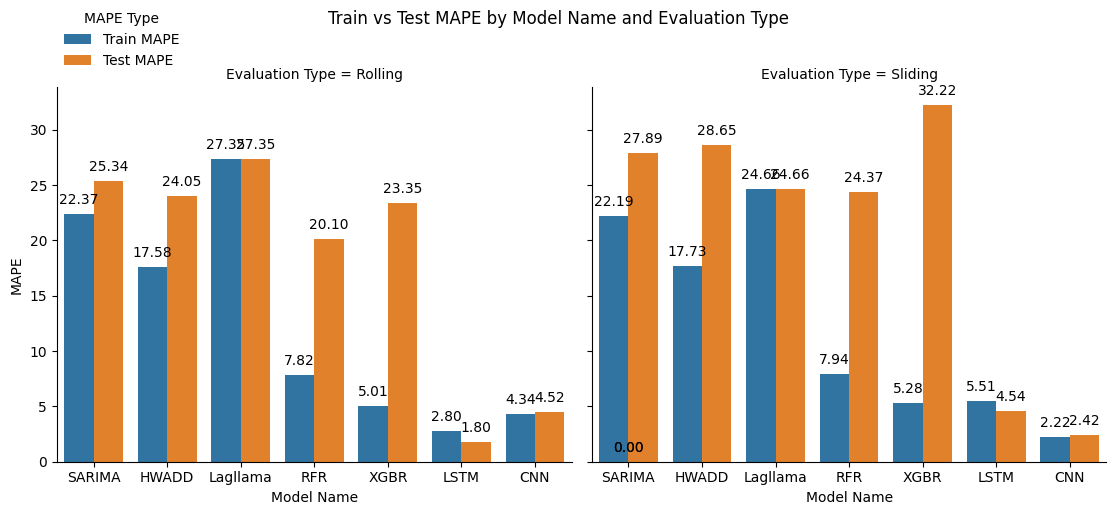

In [44]:
# Reshape the DataFrame to long format including "Evaluation Type"
mape_df = pd.melt(outpu_tran_df, 
                  id_vars=["Model Name", "Evaluation Type"], 
                  value_vars=["Train MAPE", "Test MAPE"],
                  var_name="MAPE Type", 
                  value_name="MAPE")

# Create a facet grid with one column per Evaluation Type
g = sns.catplot(
    data=mape_df,
    kind="bar",
    x="Model Name",
    y="MAPE",
    hue="MAPE Type",
    col="Evaluation Type",
    height=5,
    aspect=1
)

# Add quantity labels on each bar for every facet
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points')
# Adjust legend position
g._legend.set_title("MAPE Type")
g._legend.set_bbox_to_anchor((0.17, 0.95))  # Move legend to the top center
g._legend.set_frame_on(False)  # Optional: Remove legend background frame

g.fig.suptitle("Train vs Test MAPE by Model Name and Evaluation Type", y=1.02)
g.set_axis_labels("Model Name", "MAPE")
g._legend.set_title("MAPE Type")
plt.tight_layout()
plt.show()

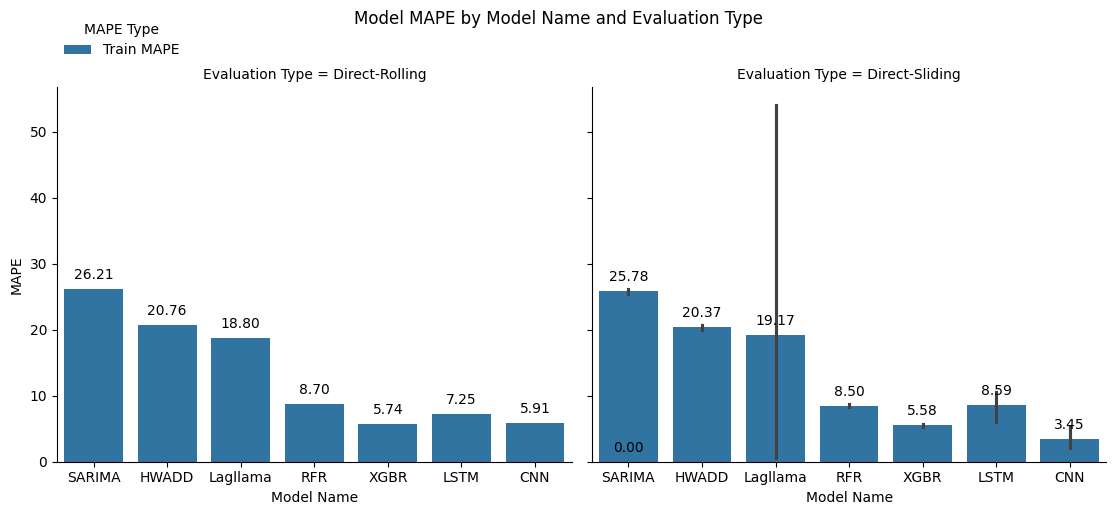

In [45]:
# Reshape the DataFrame to long format including "Evaluation Type"
mape_df = pd.melt(outpu_direct_df, 
                  id_vars=["Model Name", "Evaluation Type"], 
                  value_vars=["Train MAPE"],
                  var_name="MAPE Type", 
                  value_name="MAPE")

# Create a facet grid with one column per Evaluation Type
g = sns.catplot(
    data=mape_df,
    kind="bar",
    x="Model Name",
    y="MAPE",
    hue="MAPE Type",
    col="Evaluation Type",
    height=5,
    aspect=1
)

# Add quantity labels on each bar for every facet
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points')
# Adjust legend position
g._legend.set_title("MAPE Type")
g._legend.set_bbox_to_anchor((0.17, 0.95))  # Move legend to the top center
g._legend.set_frame_on(False)  # Optional: Remove legend background frame

g.fig.suptitle("Model MAPE by Model Name and Evaluation Type", y=1.02)
g.set_axis_labels("Model Name", "MAPE")
g._legend.set_title("MAPE Type")
plt.tight_layout()
plt.show()